# How Word Embeddings Effect NLP Models

This notebook will explore come different feature selection methods for NLP models. It will cover the following topics:

- Tokenisation
- Stopwords
- Zipfian Distributions
- Sentiment Analysis
- Bag-of-words Vectorisation
- tf\*idf Vectorisation
- Subword Encoding
- Word Embeddings

In [ ]:
%%capture
!pip install unidecode

import os
from string import punctuation
from collections import Counter

import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
from nltk import word_tokenize
from unidecode import unidecode
from nltk.corpus import stopwords

# Models necessary for this workshop
!python -m spacy download en_core_web_md
nltk.download('punkt')
nltk.download('stopwords')

# Download data
!wget https://raw.githubusercontent.com/ryancallihan/imdb-sentiment-dataset/master/imdb-sentiment-train.csv
!wget https://raw.githubusercontent.com/ryancallihan/imdb-sentiment-dataset/master/imdb-sentiment-test.csv

We will be removeing stopwords for some of these methods. [Stopwords](https://en.wikipedia.org/wiki/Stop_words) are words which, at a basic level, do not carry much "_meaning_". Words like: _the_, _and_, _or_, _is_, etc. I have included most punctuation in this as well.

In [ ]:
stopwords = stopwords.words('english') + list(punctuation)

## Data 

The data we will be looking at is the classic [IMDB Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/) dataset. It is a cleaned up sentiment analysis dataset, consisting of film reviews from IMDB. Each review is given a binary score of _Positive_ or _Negative_. It has already been divided into 25k train and 25k validation sets.

We will only be taking 10K samples for the validation because of RAM and time contraints

In [ ]:
train_df = pd.read_csv('imdb-sentiment-train.csv')
test_df = pd.read_csv('imdb-sentiment-test.csv').sample(10000)

### Preprocessing

Convert to ASCII for ease during this presentation. Will convert characters like `Ü` to `U`. It just reduces the unique token types for this workshop.

In [ ]:
train_df.text = [unidecode(t) for t in train_df.text]
test_df.text = [unidecode(t) for t in test_df.text]

[Tokenization](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) is breaking up the text into usable pieces.

A sentence like `'I don't like celery.'` might be tokenized as `['I', 'do', 'n't', 'like', 'celery', '.']`

Do a simple tokenize on the texts for ease using NLTK's [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html)

In [ ]:
train_df['tokenized'] = [[t for t in word_tokenize(r.lower()) if t not in stopwords] for r in tqdm(train_df.text)]
test_df['tokenized'] = [[t for t in word_tokenize(r.lower()) if t not in stopwords] for r in tqdm(test_df.text)]

100%|██████████| 10000/10000 [00:21<00:00, 457.54it/s]


In [ ]:
train_df.head()

,text,sentiment,tokenized
0,Steven Spielberg (at 24) had already directed ...,1,"[steven, spielberg, 24, already, directed, two..."
1,This is a very light headed comedy about a won...,1,"[light, headed, comedy, wonderful, family, son..."
2,"When I was little, my parents got this movie f...",1,"[little, parents, got, movie, watch, really, l..."
3,"Hilarious, evocative, confusing, brilliant fil...",1,"[hilarious, evocative, confusing, brilliant, f..."
4,All Dogs Go to Heaven plays on the canine crim...,1,"[dogs, go, heaven, plays, canine, criminal, un..."


## Some Minor Data Exporation

It's always good to look at the data at least a little bit before working with it.

### Class Split

The classes are evenly split, so class imbalance won't be a problem.

- `0` == _Negative_
- `1` == _Positive_

1    12500
0    12500
Name: sentiment, dtype: int64


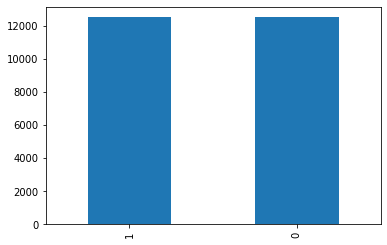

In [ ]:
print(train_df.sentiment.value_counts())
train_df.sentiment.value_counts().plot.bar()

### Review Length

We can see that the majority of reviews are roughly under 500 tokens long. Because we will be doing sentiment using a _Feed Forward_ network, we will not really need to worry about sequence length. When dealing with _Recurrent_ models, _Attention_ models, etc., it would need to be taken into consideration.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cb793bf98>]],
      dtype=object)

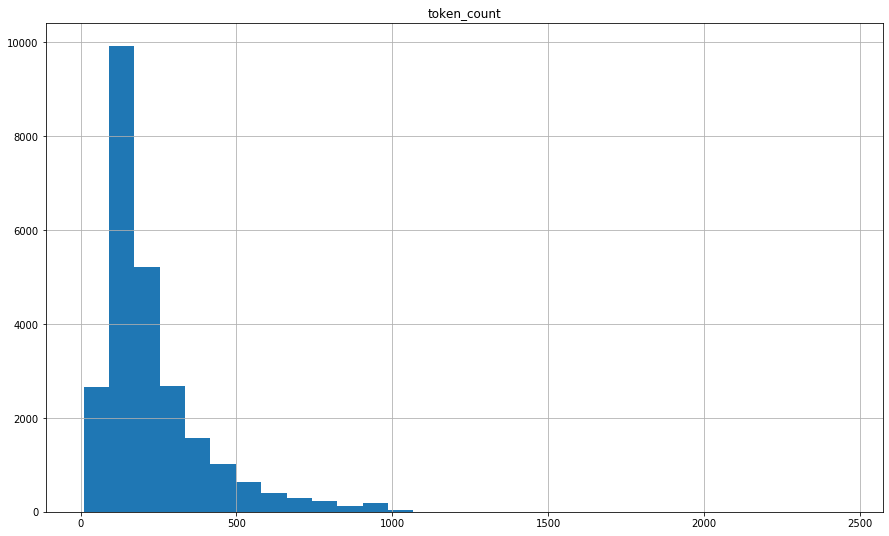

In [ ]:
train_df['token_count'] = [len(t.split()) for t in train_df['text']]
test_df['token_count'] = [len(t.split()) for t in test_df['text']]
train_df.hist(column='token_count', bins=30, figsize=(15, 9))

### Distribution of tokens

Token counts in a dataset usually have a [Zipfian Distribution](https://en.wikipedia.org/wiki/Zipf%27s_law) where the frequency of a token is inversely proportional to its rank.

The majority of _stopwords_ have a really high frequency whereas content words usually dont.

This is important for a couple of the feature extraction methods. Having a very large vocabulary can make your feature matrices especially large. 

In [ ]:
# Get token counts
tokens, counts = zip(*sorted(Counter([t.lower() for s in train_df.text for t in s.split()]).items(), key=lambda x: x[1])[::-1])
df = pd.DataFrame({
    'tokens': tokens,
    'counts': counts
})
df.sort_index(ascending=True).head(90).plot.bar(x='tokens', y='counts', figsize=(15, 9))

Our dataset certainly seems to follow a Zipfian distribution. For the sake of resources, we can limit our vocabulary by the frequency of tokens. We can remove stopwords and limit our vocab by frequency.

Even after doing that, our dataset still fits the _Zipfian_ distribution.

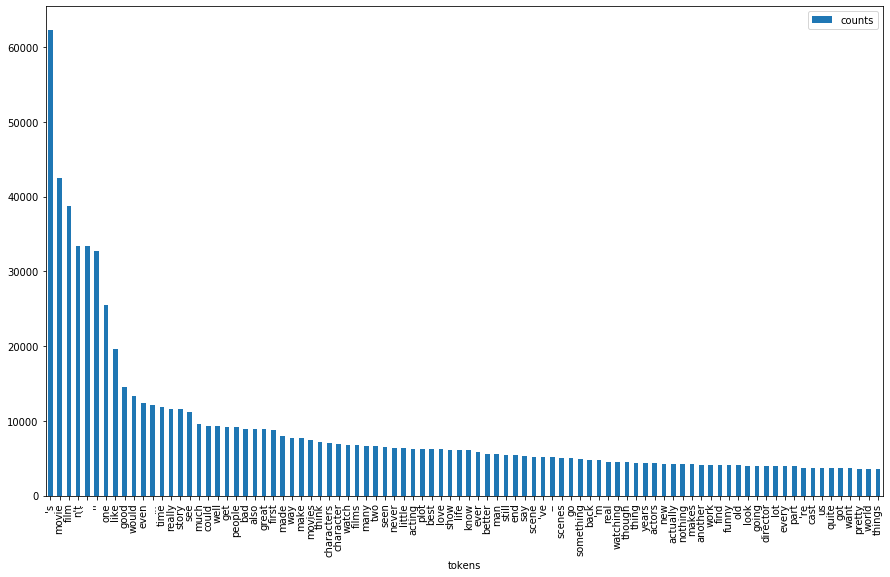

In [ ]:
# Get token counts
tokens, counts = zip(*sorted(Counter([t for s in train_df.tokenized for t in s]).items(), key=lambda x: x[1])[::-1])
df = pd.DataFrame({
    'tokens': tokens,
    'counts': counts
})

df.sort_index(ascending=True).head(90).plot.bar(x='tokens', y='counts', figsize=(15, 9))

## Testing Model

We will be testing our feature extraction on a _Feed Forward_ neural net. We will be using a [_Keras_](https://www.tensorflow.org/guide/keras) model for ease.

We will use a model with the following hyperparams:

- _Learning Rate_ == 0.0001
- _Optimizer_ == _Adam_
- _Layer Activations_ == _Sigmoid_
- _Loss_ == _Binary Crossentropy_

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)             (None, 128)               2560128   
_________________________________________________________________
dropout (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_0 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_0 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)             (None, 1)                 65        
=================================================================
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
```

In [5]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
def build_model(vector_length):
    np.random.seed(42)
    model = Sequential()
    model.add(Dense(128, activation='sigmoid', input_shape=(vector_length, )))
    model.add(Dropout(0.3))
    for _ in range(3):
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    # print(model.summary())
    return model

## Bag-of-Words Encoding

Bag-of-Words (BOW) encoding creates vectors for words in which the length of the vector is the size of the vocabulary, and each token has an index. These vectors are very sparse. Most of the elements are 0.

In [ ]:
corpus = [
  ['I', 'like', 'cheese', '.'],
  ['We', 'like', 'stinky', 'cheese', '.'],
  ['They', 'do', 'not', 'like', 'stinky', 'cheese', '!'],
  ['I', 'like', 'stinky', 'cheese', 'but', 'not', 'mild', 'cheese', '.']
]
vocab = set(t for s in corpus for t in s)
indexer = {t: i for i, t in enumerate(vocab)}
vocab_len = len(vocab)
indexer

{'!': 3,
 '.': 7,
 'I': 8,
 'They': 1,
 'We': 4,
 'but': 10,
 'cheese': 2,
 'do': 5,
 'like': 0,
 'mild': 9,
 'not': 6,
 'stinky': 11}

We can turn our sentences into vectors

In [ ]:
sent_i = 0
vec = np.zeros(vocab_len)
for t in corpus[sent_i]:
    vec[indexer[t]] += 1
vec

array([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

And then reversed. However, we can't preserve order.

In [ ]:
indexer_inverse = {v: k for k, v in indexer.items()}
for i, v in enumerate(vec):
    if v:
        print(f'Token: {indexer_inverse[i]:<7} | Count: {int(v)}')

Token: like    | Count: 1
Token: cheese  | Count: 1
Token: .       | Count: 1
Token: I       | Count: 1


[_Scikit-Learn_](https://scikit-learn.org/) is a good implementation of of this.

We will limit the total vocabulary to 20k. It will prioritize tokens with a higher frequency.

#### [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy_func(doc):
  """Must pass a dummy function to avoid sklearn automatically tokenizing."""
  return doc

one_hot = CountVectorizer(preprocessor=dummy_func, tokenizer=dummy_func, min_df=5, max_features=20000)
one_hot.fit(train_df.tokenized)
print(f'Length of vocabulary: {len(one_hot.vocabulary_)}')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Length of vocabulary: 20000


It's pretty easy to use

In [ ]:
print(f'Text: {train_df.text.values[0][:50]}')
vec = one_hot.transform([train_df.tokenized.values[0]]).toarray()
print(f'Feature Dimentions: {vec.shape}')
vec

Text: Steven Spielberg (at 24) had already directed two superb episodes of a 1971 series called "The Psychiatrist", starring Roy Thinnes. One episode had been about an emotionally troubled 12-year old boy and the other was about a vibrant young man (Clu Gulager in his best performance) who is dying of cancer. Both episodes were stunning, visually unlike anything else on TV, and emotionally complex and adult. The creators of "The Psychiatrist" were Richard Levinson and William Link, who created "Columbo" and also produced its first season.Peter Falk insisted on first rank, experienced TV directors for the first season of "Columbo", like Bernard Kowalski and Jack Smight. But Falk agreed to Spielberg after watching part of the Clu Gulagher episode of "The Psychiatrist".Spielberg says on the DVD of "Duel" that he loved Steven Bochco's "Murder by the Book" script (based on a Levinson/Link story), and he tried to make the production look like a million dollar feature, even thought he had a l

array([[14,  0,  0, ...,  0,  0,  0]])

### Training

In [ ]:
oh_model = build_model(len(one_hot.vocabulary_))
oh_history = oh_model.fit(
    x=one_hot.transform(train_df.tokenized), 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(one_hot.transform(test_df.tokenized), test_df.sentiment)
    )

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 13s 511us/sample - loss: 0.7177 - acc: 0.5057 - val_loss: 0.6816 - val_acc: 0.8152
Epoch 2/10
25000/25000 [==============================] - 12s 490us/sample - loss: 0.6386 - acc: 0.6304 - val_loss: 0.4759 - val_acc: 0.8496
Epoch 3/10
25000/25000 [==============================] - 12s 491us/sample - loss: 0.3731 - acc: 0.8609 - val_loss: 0.3013 - val_acc: 0.8828
Epoch 4/10
25000/25000 [==============================] - 12s 490us/sample - loss: 0.2750 - acc: 0.8984 - val_loss: 0.2806 - val_acc: 0.8887
Epoch 5/10
25000/25000 [==============================] - 12s 485us/sample - loss: 0.2387 - acc: 0.9133 - val_loss: 0.2778 - val_acc: 0.8905
Epoch 6/10
25000/25000 [==============================] - 12s 478us/sample - loss: 0.2117 - acc: 0.9235 - val_loss: 0.2788 - val_acc: 0.8910
Epoch 7/10
25000/25000 [==============================] - 12s 470us/sample - loss: 0.1906 - acc: 0.9318 

### Prediction

In [ ]:
def oh_predict(text):
  return oh_model.predict(one_hot.transform([text.lower().split()]))[0][0]

def oh_print(text):
  print(f'{oh_predict(text):<.5f} | {text}')

t1 = '''Tacos in England is absolutely terrible .'''
t2 = '''Tacos in England absolutely terible .'''
t3 = '''Tacos in Prague are not so bad .'''
t4 = '''Mexican food in SD is the best .'''
t5 = '''I'm a big fan of tacos .'''

oh_print(t1)
oh_print(t2)
oh_print(t3)
oh_print(t4)
oh_print(t5)

0.19578 | Tacos in England is absolutely terrible .
0.62020 | Tacos in England absolutely terible .
0.20484 | Tacos in Prague are not so bad .
0.69633 | Mexican food in SD is the best .
0.50702 | I'm a big fan of tacos .


## TF*IDF

[_tf*idf_](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a widely used technique in NLP for feature and keyword extraction. 

By combining the frequency (how many times a term appears in a document) by the inverse document frequency (how many documents a term appears in), we are able to filter out common words and promote unique content words.

[_Scikit-Learn_](https://scikit-learn.org/) also has a very good implementation of it.

#### [`TFIDFVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=dummy_func, tokenizer=dummy_func, min_df=5, max_features=20000)
tfidf.fit(train_df.tokenized)
print(f'Length of vocabulary: {len(tfidf.vocabulary_)}')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Length of vocabulary: 20000


### Training

In [ ]:
tfidf_model = build_model(len(tfidf.vocabulary_))
tfidf_history = tfidf_model.fit(
    x=tfidf.transform(train_df.tokenized), 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(tfidf.transform(test_df.tokenized), test_df.sentiment)
    )

Train on 25000 samples, validate on 10000 samples
Epoch 1/10
25000/25000 [==============================] - 11s 458us/sample - loss: 0.7193 - acc: 0.5014 - val_loss: 0.6929 - val_acc: 0.4995
Epoch 2/10
25000/25000 [==============================] - 11s 448us/sample - loss: 0.7096 - acc: 0.5054 - val_loss: 0.6926 - val_acc: 0.4995
Epoch 3/10
25000/25000 [==============================] - 11s 457us/sample - loss: 0.7076 - acc: 0.4997 - val_loss: 0.6922 - val_acc: 0.5005
Epoch 4/10
25000/25000 [==============================] - 12s 463us/sample - loss: 0.7024 - acc: 0.5031 - val_loss: 0.6916 - val_acc: 0.4995
Epoch 5/10
25000/25000 [==============================] - 11s 455us/sample - loss: 0.7004 - acc: 0.5042 - val_loss: 0.6898 - val_acc: 0.4996
Epoch 6/10
25000/25000 [==============================] - 12s 468us/sample - loss: 0.6945 - acc: 0.5213 - val_loss: 0.6845 - val_acc: 0.5287
Epoch 7/10
25000/25000 [==============================] - 11s 447us/sample - loss: 0.6810 - acc: 0.5638 

### Prediction

In [ ]:
def tfidf_predict(text):
  return tfidf_model.predict(tfidf.transform([text.lower().split()]))[0][0]

def tfidf_print(text):
  print(f'{tfidf_predict(text):<.5f} | {text}')

tfidf_print(t1)
tfidf_print(t2)
tfidf_print(t3)
tfidf_print(t4)
tfidf_print(t5)

0.20991 | Tacos in England is absolutely terrible .
0.69588 | Tacos in England absolutely terible .
0.26835 | Tacos in Prague are not so bad .
0.80186 | Mexican food in SD is the best .
0.71495 | I'm a big fan of tacos .


## Subword Encoding

Also known as [_Byte Pair Encoding_](https://en.wikipedia.org/wiki/Byte_pair_encoding). This feature extraction has become very popular in the past couple years. Because writing is frequently non-standard, BOW encoding is often not ideal. Because BOW and tfidf encoding require a static vocabulary, it cannot handle new words, misspelled words, etc. If the vocabulary was built to include _terrible_ but not _terrible_, it could have a negative effect on the model.

_Byte Pair Encoding_ starts by looking at the training dataset on a character level. It find the most frequent pairs of characters, registers that as a subword, and then will treat each occurence of that sequence as one unit. 

- `H e r e  i s  a  n i c e  s e n t e n c e .`
- `H e r e  i s  a  n i c e  s en t en c e .`
- `H e r e  i s  a  n i ce  s en t en ce .`
- ...

This is able to capture things like word stems and morphology.

Tensorflow as a good and efficient implementation of this.

#### [`SubwordTextEncoder`](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder)

In [ ]:
import tensorflow_datasets as tfds

swe_encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    train_df.text, target_vocab_size=20000)
print(f'Vocabulary size: {encoder.vocab_size}')

NameError: ignored

We can see how it splits up text here.

In [ ]:
text = 'Here is a standard sentence.'  # Standard Words
# text = 'This sentence is more standarder!'  # Non-standard word
enc = swe_encoder.encode(text)
print(f'Encoded: {enc}', '\n', '-'*10)
for e in enc:
    print(f'Decoded: {swe_encoder.decode([e])}')

However, we still need to convert our Subword encodings into vectors. They will function just like the one-hot vectors

In [ ]:
swe_train_x = np.zeros((len(train_df), encoder.vocab_size))
for i, text in enumerate(train_df.text):
    for e in swe_encoder.encode(text):
        swe_train_x[i, e] += 1

swe_test_x = np.zeros((len(test_df), encoder.vocab_size))
for i, text in enumerate(test_df.text):
    for e in swe_encoder.encode(text):
        swe_test_x[i, e] += 1

### Training

In [ ]:
swe_model = build_model(swe_encoder.vocab_size)

swe_history = swe_model.fit(
    x=swe_train_x, 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(swe_test_x, test_df.sentiment)
    )

### Prediction

In [ ]:
def swe_predict(text):
    x = np.zeros((1, swe_encoder.vocab_size))
    for e in swe_encoder.encode(text):
        x[0, e] += 1
    return swe_model.predict(x)[0][0]

def swe_print(text):
    print(f'{swe_predict(text):<.5f} | {text}')

swe_print(t1)
swe_print(t2)
swe_print(t3)
swe_print(t4)
swe_print(t5)

## GloVe

_Word Embeddings_ are now the new normal for NLP. Two of the first, widely used, and really successful embedding algorithms were [_GloVe_](https://nlp.stanford.edu/projects/glove/) and [_Word2Vec_](https://en.wikipedia.org/wiki/Word2vec). We will be using _GloVe_ here because it is so easy to use with [_spaCy_](https://spacy.io/)

Word embeddings start to fix a couple major problem with one-hot and tfidf. 

- __Dimentionality Reduction__: The vectors we used earlier are quite large with a dimention of 20k. _GloVe_ vectors have a dimention of 300. 
- __Semantics__: _"You shall know a word by the company it keeps"_ (Firth). These vectors will group words which have a similar meaning together. So, a word like "_bad_" will be close to "_terrible_", similar to "_good_", but very dissimilar to "_taco_".

We will be using [_spaCy_](https://spacy.io/) to load our vectors

In [ ]:
import en_core_web_md  # 
from spacy.tokens import Doc

In [ ]:
nlp = en_core_web_md.load(disable=['tagger', 'parser', 'ner'])

In [ ]:
glove_train_x = np.array([Doc(nlp.vocab, words=sent).vector.tolist() for sent in tqdm(train_df.tokenized, disable=True)])
glove_test_x = np.array([Doc(nlp.vocab, words=sent).vector.tolist() for sent in tqdm(test_df.tokenized, disable=True)])

### Training

In [ ]:
glove_model = build_model(300)

In [ ]:
glove_history = glove_model.fit(
    x=glove_train_x, 
    y=train_df.sentiment,
    epochs=10,
    validation_data=(glove_test_x, test_df.sentiment)
    )

### Prediction

In [ ]:
def glove_predict(text):
  x = np.array([Doc(nlp.vocab, words=text.lower().split()).vector.tolist()])
  return glove_model.predict(x)[0][0]

def glove_print(text):
  print(f'{swe_predict(text):<.5f} | {text}')

swe_print(t1)
swe_print(t2)
swe_print(t3)
swe_print(t4)
swe_print(t5)

## Conclusion

This was by no means a comprehensive comparison of NLP feature selection. But we can see that the features we use can make a large difference

In [ ]:
print(f"{'O-H':<5} | {'TFIDF':<5} | {'SWE':<5} | {'GloVe':<5} | {'Text'}")
print(f"{oh_predict(t1):.3f} | {tfidf_predict(t1):.3f} | {swe_predict(t1):.3f} | {glove_predict(t1):.3f} | {t1}")
print(f"{oh_predict(t2):.3f} | {tfidf_predict(t2):.3f} | {swe_predict(t2):.3f} | {glove_predict(t2):.3f} | {t2}")
print(f"{oh_predict(t3):.3f} | {tfidf_predict(t3):.3f} | {swe_predict(t3):.3f} | {glove_predict(t3):.3f} | {t3}")
print(f"{oh_predict(t4):.3f} | {tfidf_predict(t4):.3f} | {swe_predict(t4):.3f} | {glove_predict(t4):.3f} | {t4}")
print(f"{oh_predict(t5):.3f} | {tfidf_predict(t5):.3f} | {swe_predict(t5):.3f} | {glove_predict(t5):.3f} | {t5}")

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
fig = plt.figure(figsize=(15, 4))
plt.plot(glove_hist.history['val_acc'], color='red')
plt.plot(swe_history.history['val_acc'], color='blue')
plt.plot(tfidf_history.history['val_acc'], color='green')
plt.plot(oh_history.history['val_acc'], color='orange')

plt.plot(glove_hist.history['acc'], ls='--', color='red')
plt.plot(swe_history.history['acc'], ls='--', color='blue')
plt.plot(tfidf_history.history['acc'], ls='--', color='green')
plt.plot(oh_history.history['acc'], ls='--', color='orange')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['GloVe Val', 'SWE Val', 'TFIDF Val', 'One-Hot Val', 'GloVe', 'SWE', 'TFIDF', 'One-Hot'], loc='best')
plt.show()

# Plot training & validation loss values
fig = plt.figure(figsize=(15, 4))
plt.plot(glove_history.history['val_loss'], color='red')
plt.plot(swe_history.history['val_loss'], color='blue')
plt.plot(tfidf_history.history['val_loss'], color='green')
plt.plot(oh_history.history['val_loss'], color='orange')

plt.plot(glove_hist.history['loss'], ls='--', color='red')
plt.plot(swe_history.history['loss'], ls='--', color='blue')
plt.plot(tfidf_history.history['loss'], ls='--', color='green')
plt.plot(oh_history.history['loss'], ls='--', color='orange')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['GloVe Val', 'SWE Val', 'TFIDF Val', 'One-Hot Val', 'GloVe', 'SWE', 'TFIDF', 'One-Hot'], loc='best')
plt.show()
